In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import gstools as gs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# import the customized modules for hierarchical bayes

from sklearn.decomposition import PCA
from utils.MC_case1_linear_forward_volume_averaging import *
from utils.visualization_linear_forward_smooth_filter import *
from utils.KMedoids import KMedoids
from utils.DGSA_light import DGSA_light

from inversion_methods.linear_inverse_m import *
from inversion_methods.linear_inverse_theta_McMC import *
from inversion_methods.nonlinear_inverse_theta_jointML import *

/mnt/batch/tasks/shared/LS_root/mounts/clusters/pythoninstance4cores/code/Users/hierarchicalBayes/hierarchical_Bayes_stash/utils


Using TensorFlow backend.


# Load and visualize observed data

In [3]:
path = os.getcwd()
subpath = '/examples/case1_linear_forward_volume_averaging/'

# linear forward modeling: smooth filter 
G = np.load(path+subpath+'G.npy')

num_prior_sample = 5000
num_x = 70
num_y = 30
num_m = G.shape[1]
num_d = G.shape[0]

# observed data
d_obs = np.load(path+subpath+'d_obs.npy')

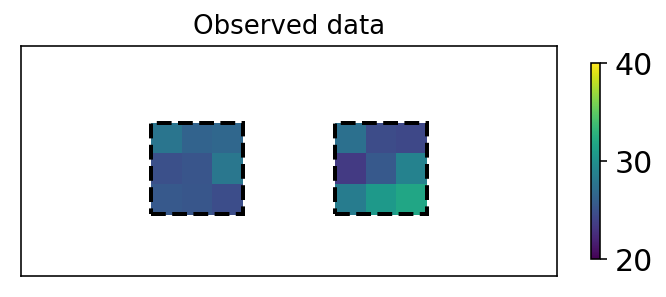

In [4]:
visualize_one_d(d_obs,vmin = 20, vmax = 40)

## Sneak peek: true model variables

In [5]:
# true global variable, theta_true
theta_name = ['mean', 'variance', 'max_range', 'min_range', 'anisotropy']
theta_true = np.load(path+subpath+'theta_true.npy')
# true spatial variable, m_true
m_true = np.load(path+subpath+'m_true.npy')

In [6]:
print_theta(theta_true)

       mean  variance  max_range  min_range  anisotropy
theta    29        12         25          8          20


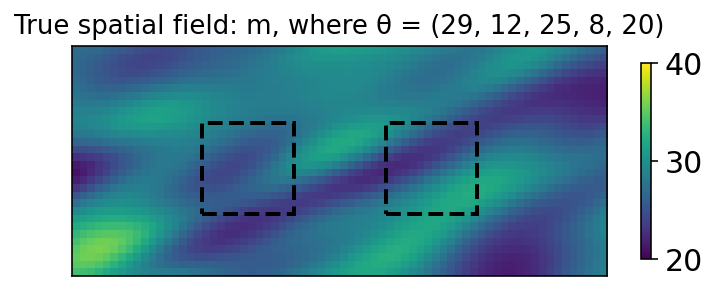

In [7]:
visualize_one_m(m_true,vmin = 20, vmax = 40, title = 'True spatial field: m, where \u03B8 = '+str(tuple(theta_true)))

# Monte Carlo sampling: m, theta, d

In [8]:
# MC sampled global variable, theta
theta = np.load(path+subpath+'theta.npy')
# MC sampled spatial variable, m
m = np.load(path+subpath+'m.npy')
# MC sampled spatial variable, d
d = np.load(path+subpath+'d.npy')

In [9]:
print_theta_multiple(theta)

              mean   variance  max_range  min_range  anisotropy
theta_1  30.423913  15.747325  18.830030  14.494317   69.180827
theta_2  30.933477   9.406175  24.624702   5.887289  109.443076
theta_3  28.555789  11.173404  26.036375   6.988013   51.519747
theta_4  29.250692  14.836677  23.440118  11.300607   74.997659
theta_5  31.988973  12.813007  27.434888   8.611011   94.795266
theta_6  28.512650  11.664695  20.541960   8.290432   95.263026
theta_7  28.715972  13.226335  21.792759  13.545348   33.574809
theta_8  31.011702  11.659110  24.292955  14.288201  165.201616


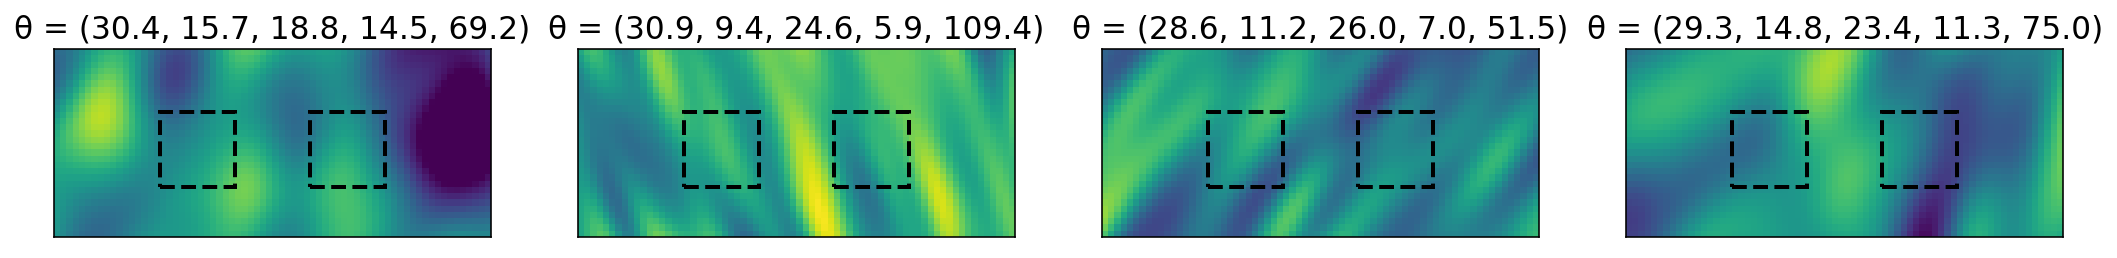

In [10]:
plt.rcParams.update({'font.size': 13})
visualize_multiple_m(m, head = 4,vmin = 20,vmax = 40,theta = theta)

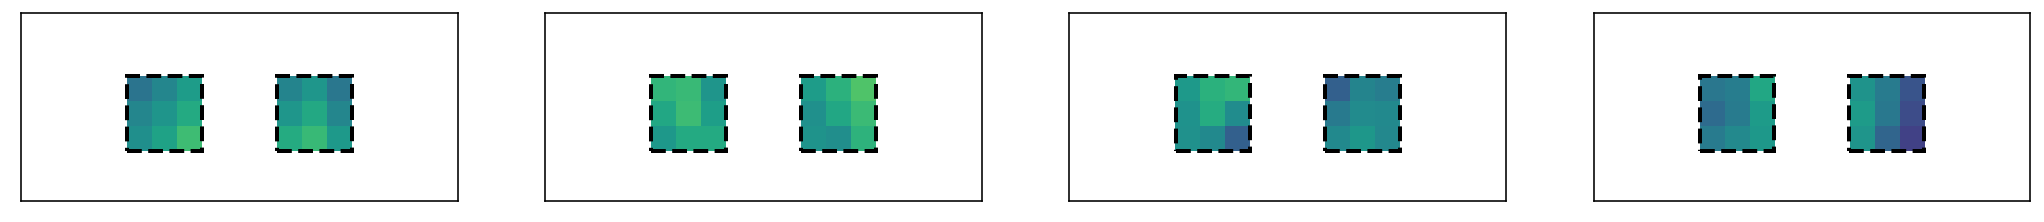

In [11]:
visualize_multiple_d(d, head = 4,vmin = 20,vmax = 40)

# Sensitivity analysis

## Sensitivity analysis on d

In [18]:
# Sensitivity analysis on d
dgsa_d_theta = DGSA_light(theta, d.T, theta_name,n_clsters=4,n_boots = 3000)
dgsa_d_theta['name'] = theta_name
dgsa_d_theta['sensitive'] = (dgsa_d_theta[0]>1)*1

100%|██████████| 3000/3000 [00:08<00:00, 371.91it/s]


(0.0, 10.0)

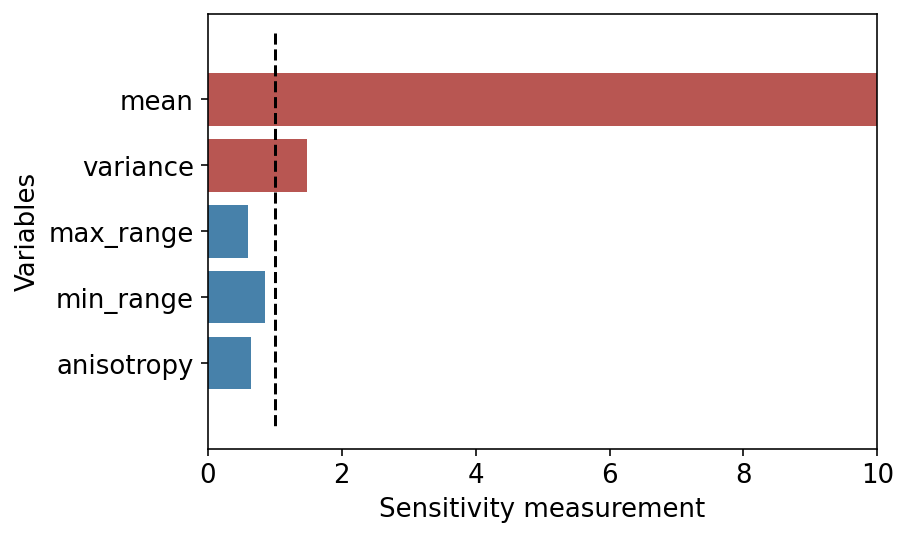

In [12]:
sns.barplot(x = 0,y = 'name', data=dgsa_d_theta, palette=colors_from_values(dgsa_d_theta['sensitive'], "RdBu_r"))
plt.vlines(x = 1, ymin = -1, ymax = len(theta_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,10)
#plt.title('Sensitivity analysis: euclidian distance between data variables')

## Sensitivity analysis on principal components of d

In [13]:
# PCA on data variables and d_obs
num_pcs = d.shape[0]
pca = PCA(n_components=num_pcs)
pca.fit(d.T)
d_pcs = pca.transform(d.T)
d_obs_pcs = pca.transform(d_obs.reshape(1,num_d))

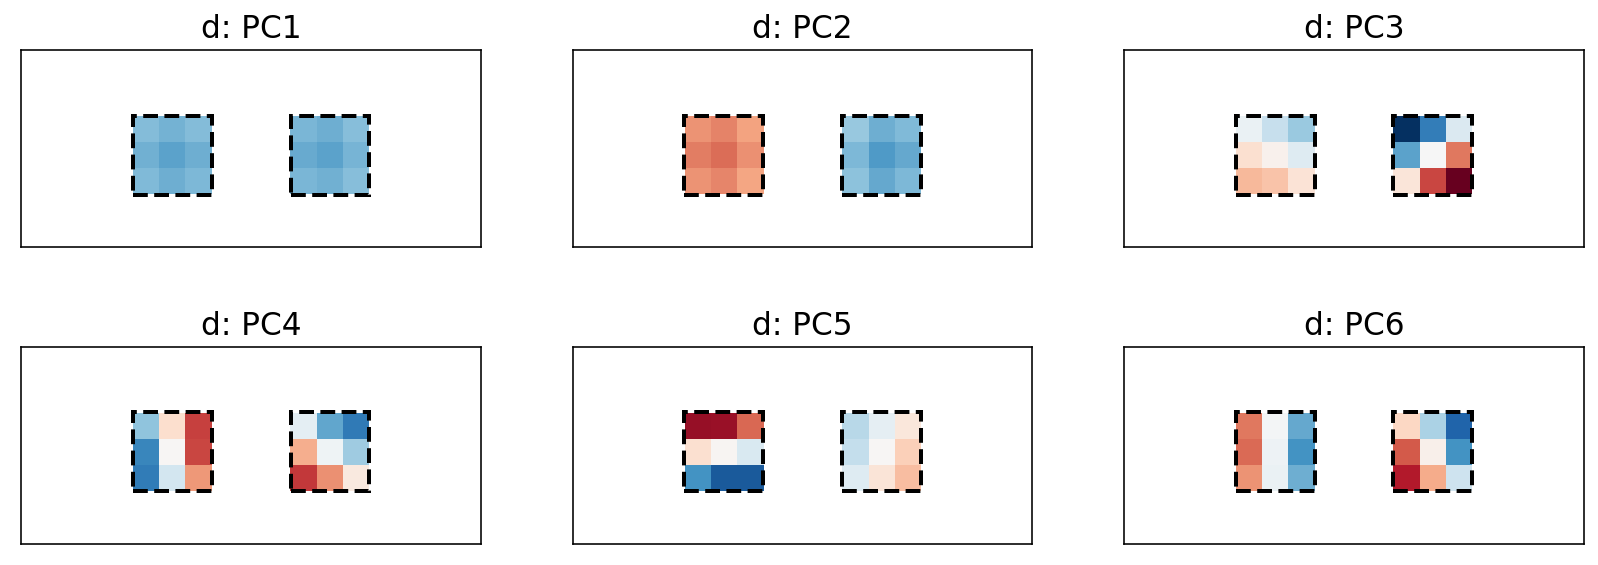

In [14]:
visualize_multiple_d_pcs(pca.components_.T,head = 6, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')

In [15]:
# Sensitivity analysis on principal components of d
num_theta = theta.shape[1]
dgsa_measures = np.zeros((num_theta,num_d))
for pc_idx in range(num_d):
    dgsa_measures[:,pc_idx:(pc_idx+1)] = DGSA_light(theta, d_pcs[:,pc_idx:(pc_idx+1)],theta_name,n_clsters=4,n_boots = 3000)

100%|██████████| 3000/3000 [00:07<00:00, 390.64it/s]


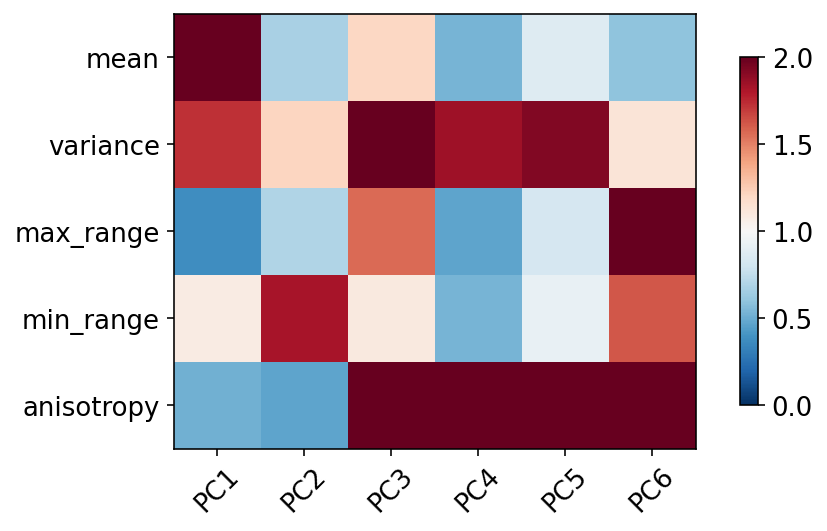

In [16]:
# Visualize the sensitivity analysis result
head = 6
matplotlib.rcParams.update({'font.size': 13})
plt.figure(figsize = [8,4])
plt.imshow(dgsa_measures[:,:head],vmin = 0, vmax = 2, cmap = 'RdBu_r')
plt.colorbar(shrink = 0.8)
plt.xticks(np.arange(head), ['PC'+str(idx+1) for idx in range(head)],rotation = 45)
plt.yticks(np.arange(num_theta), theta_name)
#plt.title('Sensitivity analysis: euclidian distance between data variables in principal component spaces')
plt.show()

# Scenario A: a fixed global variable, update spatial variable only

We choose a deterministic global variable (theta) in Scenario A and only update the spatial variable. 

Posterior results will be more reasonable if we have a 'good guess' on the global variable. However, we might still underestimate the uncertainty. 

If we have a 'bad guess' on the global variable, then the inversion on the spatial field will be also biased, and far away from posterior given our observed data.

**Guess 1**: 
theta_guess_1 = [29, 12, 25, 8, 45]

In [17]:
theta_guess_1 = [29, 12, 25, 8, 45]

In [18]:
# linear inversion on spatial variable, m
mu_pos, cov_m_pos = bayes_linear_gauss_closed_form(theta_guess_1,G,d_obs)
m_pos_sampled = sample_mvn(mu_pos, cov_m_pos)

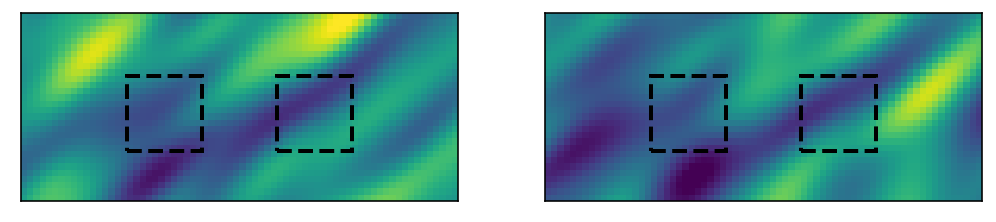

In [19]:
# Posterior realizations
visualize_multiple_m(m_pos_sampled,head = 2)

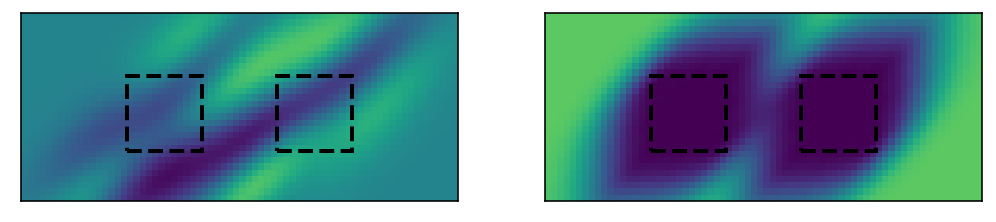

In [20]:
# Posterior mean and variance
visualize_mean_var(mu_pos, cov_m_pos)

**Guess 2**: 
theta_guess_1 = [29, 12, 25, 8, 110]

In [21]:
theta_guess_2 = [29, 12, 25, 8, 110]

In [22]:
# linear inversion on spatial variable, m
mu_pos, cov_m_pos = bayes_linear_gauss_closed_form(theta_guess_2,G,d_obs)
m_pos_sampled = sample_mvn(mu_pos, cov_m_pos)

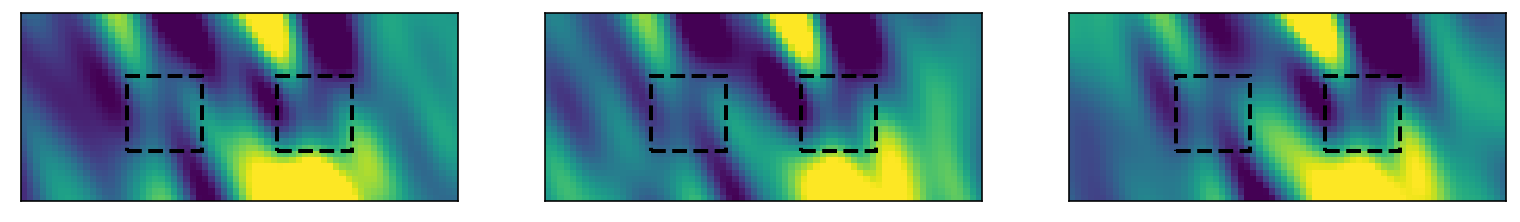

In [23]:
# Posterior realizations
visualize_multiple_m(m_pos_sampled,head = 3)

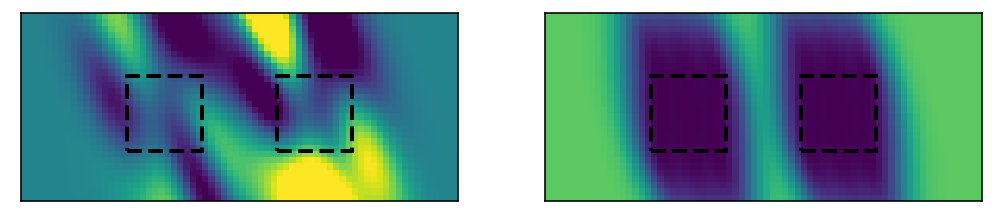

In [24]:
# Posterior mean and variance
visualize_mean_var(mu_pos, cov_m_pos)

# Scenario B: prior uncertain global variable, update spatial variable only

Suppose we estimate the covariance matrix of spatial variable using the Monte Carlo samples. Then use this estimated covariance matrix to perform Bayes-linear-Gauss inversion. 

In [25]:
mu_pos,cov_m_pos = bayes_linear_gauss_MC(m.reshape(num_prior_sample,-1).T,d,G,d_obs)
m_pos_sampled = sample_mvn(mu_pos, cov_m_pos)

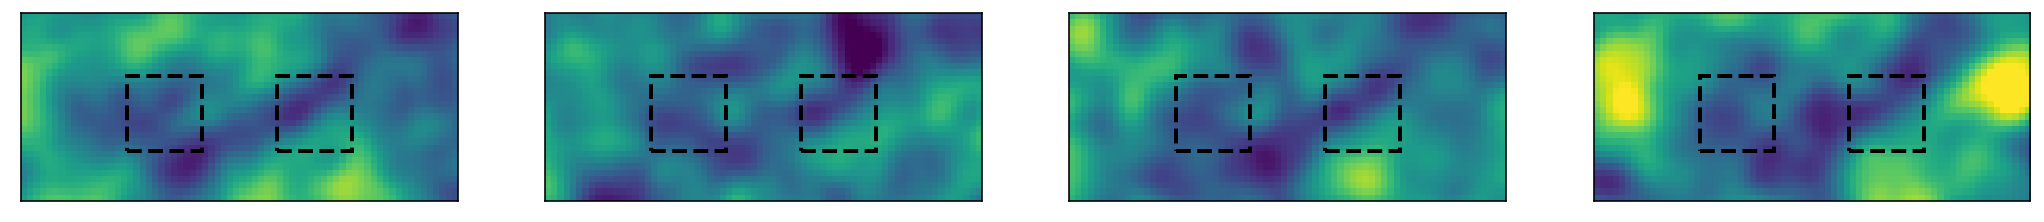

In [26]:
# Posterior realizations
visualize_multiple_m(m_pos_sampled,head = 4)

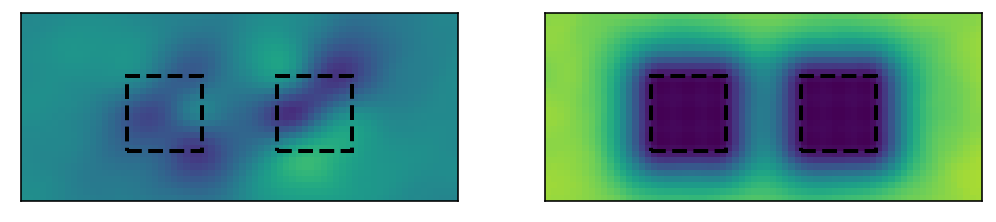

In [27]:
# Posterior mean and variance
visualize_mean_var(mu_pos, cov_m_pos)

However, these prior Monte Carlo samples include many different spatial covariances because here we have uncertain global variables in prior. Therefore, one covariance matrix estimation from all MC samples does not represent different covariance matrixes for different samples. 


To estimate the posterior distribution of spatial variable, we can solve Bayes-linear-Gauss problem for each possible global variable. In scenario B, we solve Bayes-linear-Gauss problem for each possible global variable in prior. 



In [28]:
# update spatial variable only given different uncertain global variable
num_scenario_B = 100
mu_pos_en = np.zeros(num_x*num_y)
cov_m_pos_en = np.zeros((num_x*num_y,num_x*num_y))
m_pos_scenario_B = np.zeros((num_scenario_B,num_m))

for iter_num in tqdm(range(num_scenario_B)):
    theta_current = theta[iter_num,:]
    mu_pos, cov_m_pos = bayes_linear_gauss_closed_form(theta_current,G,d_obs)
    mu_pos_en = mu_pos_en+mu_pos
    cov_m_pos_en = cov_m_pos_en+cov_m_pos
    m_pos_sampled = sample_mvn(mu_pos, cov_m_pos,num_sample=1)
    m_pos_scenario_B[iter_num,:] = m_pos_sampled.reshape(-1)

100%|██████████| 100/100 [06:11<00:00,  3.72s/it]


In [29]:
mu_pos_en = mu_pos_en/num_scenario_B
cov_m_pos_en = cov_m_pos_en/num_scenario_B

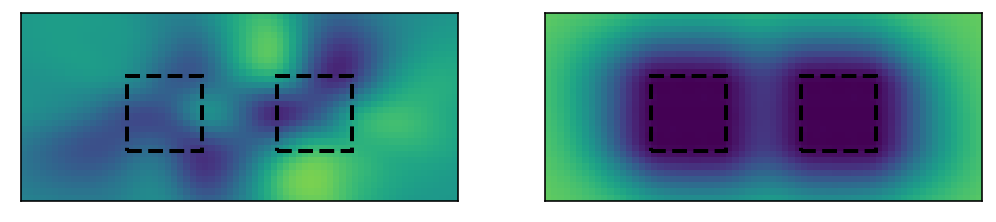

In [30]:
visualize_mean_var(mu_pos_en, cov_m_pos_en)

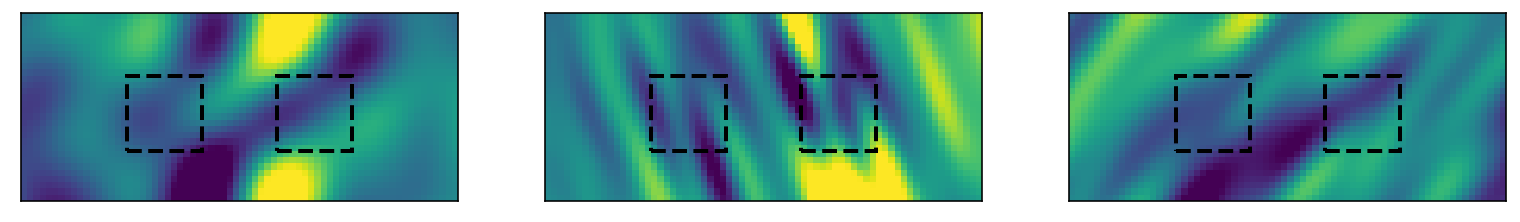

In [31]:
# Posterior realizations
visualize_multiple_m(m_pos_scenario_B,head = 3)

# Scenario C: prior uncertain global variable, update both global variable and spatial variable

## Joint distribution estimation using Monte Carlo ensembles, posterior $\theta$

In [21]:
prior_min_theta = np.array([28,9,15,5,0])
prior_max_theta = np.array([32,16,30,15,180])

# ML dimension reduction
S_d, S_d_obs,pred_train, y_train, pred_test,y_test,history = ML_dimension_reduction(d.T, d_obs, 
                                                                                    theta,
                                                                                    prior_min_theta, prior_max_theta, 
                                                                                    custom_loss_function_case1,
                                                                                    num_input=18,
                                                                                    learning_rate = 2.5e-3, 
                                                                                    num_epoch = 1000,
                                                                                    batch_size = 250)

0epoch [00:00, ?epoch/s]

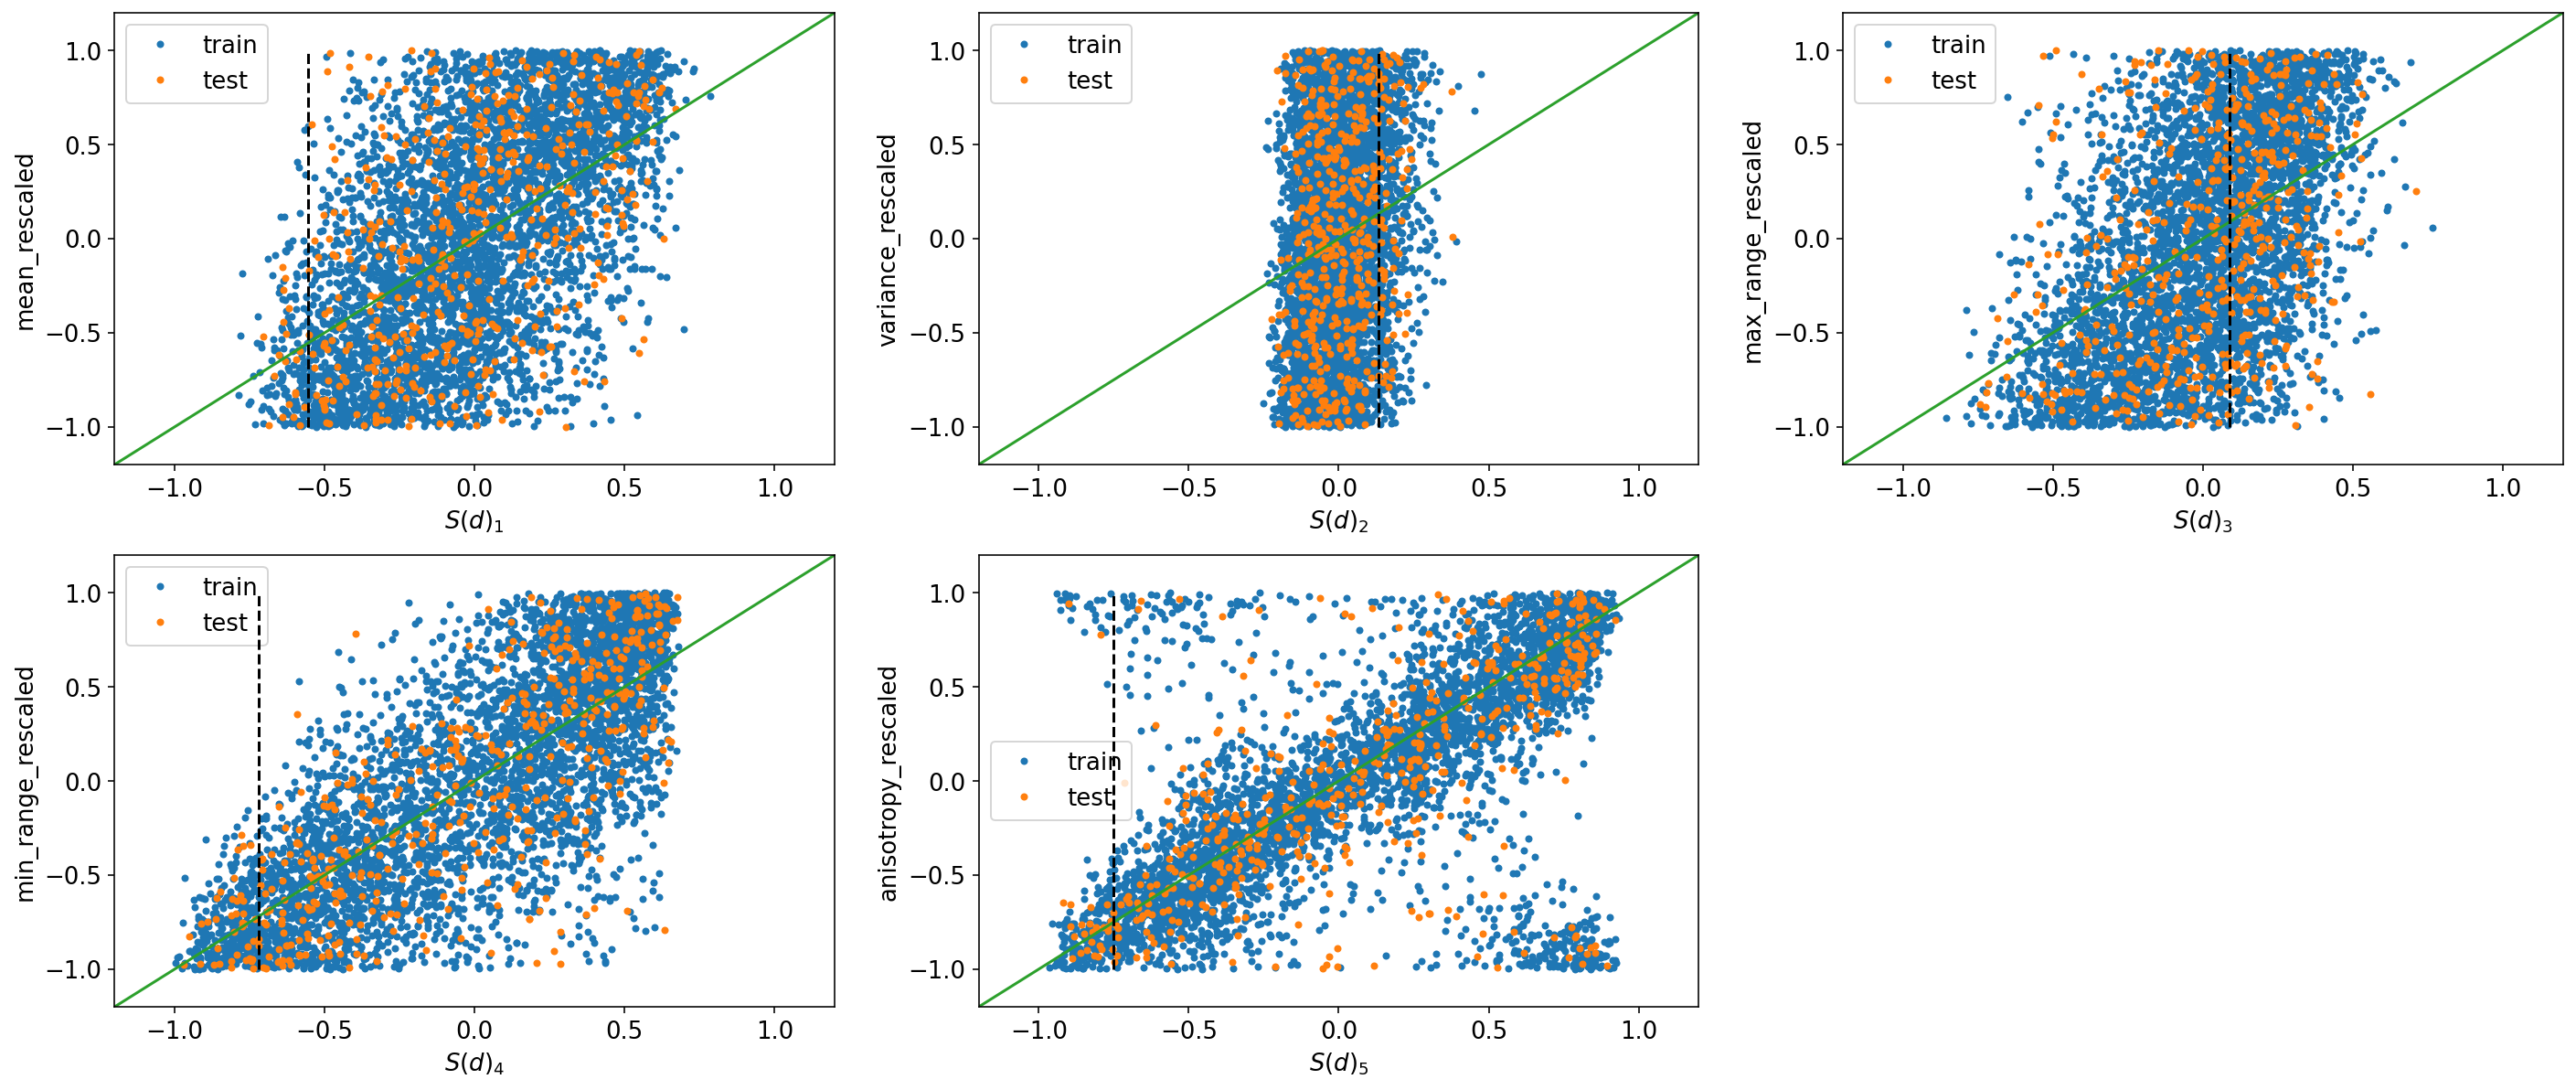

In [22]:
# visualize ML dimenison reduction result
ML_dimension_reduction_vis(pred_train, y_train, pred_test, y_test, S_d_obs, theta_name)

(-2.1999998741846993,
 2.1999980323984105,
 -0.09981612390837842,
 2.099990800660525)

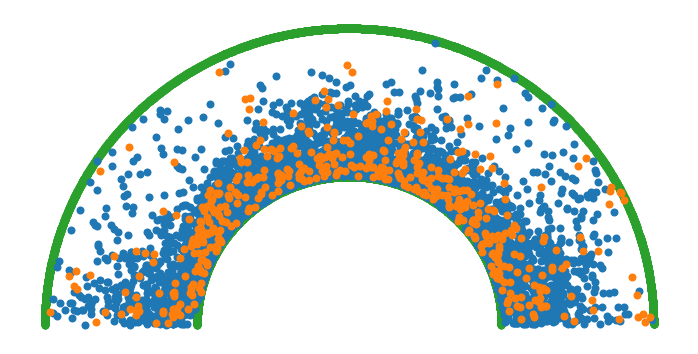

In [23]:
# mismatch of the anisotropy
plt.figure(figsize = [6,3])
plt.plot(np.cos((y_train[:,-1]+1)*np.pi/2),
         np.sin((y_train[:,-1]+1)*np.pi/2),'.', c= 'C2')
plt.plot(2*np.cos((y_train[:,-1]+1)*np.pi/2),
         2*np.sin((y_train[:,-1]+1)*np.pi/2),'.', c= 'C2')
for i in range(y_train.shape[0]):
    abs1 = np.abs(pred_train[i,-1]-y_train[i,-1])
    abs2 = 2-abs1
    scale = np.min([abs1, abs2])
    plt.plot([(scale+1)*np.cos((y_train[i,-1]+1)*np.pi/2)],
             [(scale+1)*np.sin((y_train[i,-1]+1)*np.pi/2)],'.', c= 'C0')
for i in range(y_test.shape[0]):
    abs1 = np.abs(pred_test[i,-1]-y_test[i,-1])
    abs2 = 2-abs1
    scale = np.min([abs1, abs2])
    
    plt.plot([(scale+1)*np.cos((y_test[i,-1]+1)*np.pi/2)],
             [(scale+1)*np.sin((y_test[i,-1]+1)*np.pi/2)],'.', c= 'C1')
plt.axis('off')

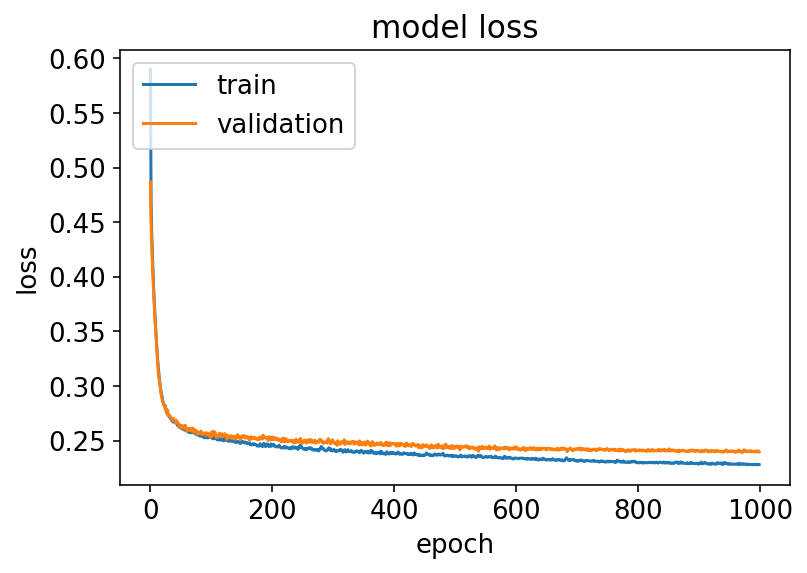

In [35]:
# visualize training history
history_plot(history)

In [52]:
prior_min_theta = np.array([28,9,15,5,0])
prior_max_theta = np.array([32,16,30,15,180])
# posterior sampling from joint distribution
theta_pos_MC = posterior_global_samples_jointML(S_d, S_d_obs, theta, prior_min_theta, prior_max_theta)

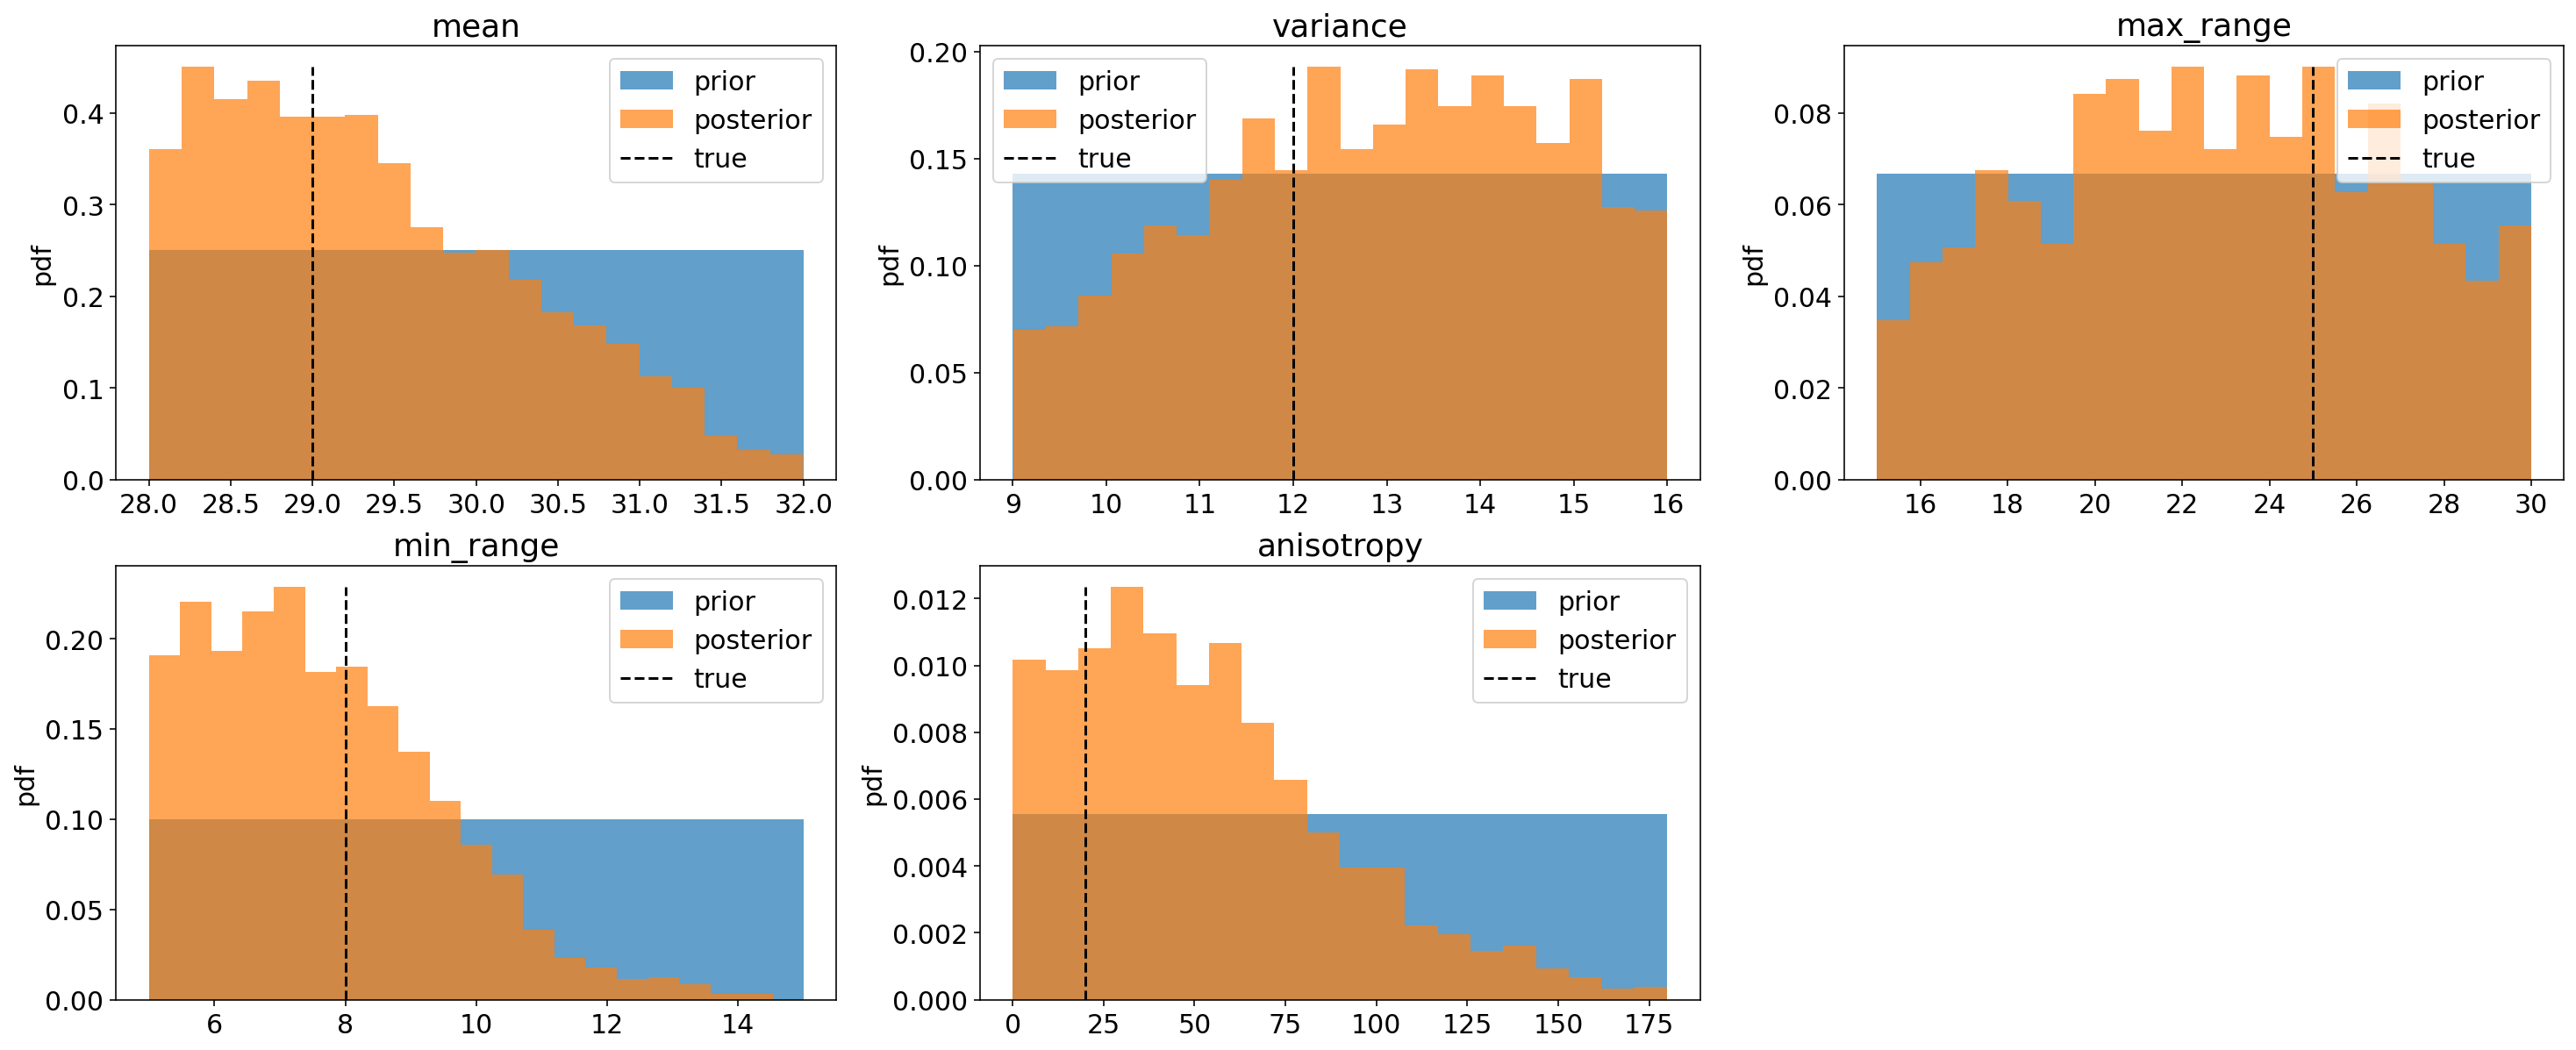

In [53]:
# visualize prior and posterior
prior_pos_theta(theta, theta_pos_MC, theta_true, theta_name)

### Different levels of errors

In [39]:
# add the error
d_var = 13
error_var_scale = np.array([0,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5])*d_var
train_loss = np.zeros(len(error_var_scale))
val_loss = np.zeros(len(error_var_scale))
theta_list = []
d_obs_list = np.zeros((num_d,len(error_var_scale)))

train_loss[0] = history.history['custom_loss_function_case1'][-1]
val_loss[0] = history.history['val_custom_loss_function_case1'][-1]
theta_list.append(theta_pos_MC)
d_obs_list[:,0:1] = d_obs

In [40]:
for i, error_level in enumerate(error_var_scale[1:], start=1):
    epsilon = np.random.multivariate_normal(np.zeros(num_d),
                                            np.identity(num_d)*error_level, num_prior_sample).T
    epsilon_obs = np.random.multivariate_normal(np.zeros(num_d),
                                                np.identity(num_d)*error_level, 1).T
    d_with_error = d + epsilon 
    d_obs_error = d_obs + epsilon_obs
    d_obs_list[:,i:(i+1)] = d_obs_error
    
    # ML dimension reduction with error
    S_d, S_d_obs, pred_train, y_train, pred_test,y_test,history = ML_dimension_reduction(d_with_error.T, d_obs_error, 
                                                                                         theta, prior_min_theta, 
                                                                                         prior_max_theta, 
                                                                                         custom_loss_function_case1,
                                                                                         learning_rate = 2.5e-3, 
                                                                                         num_epoch = 1000, 
                                                                                         batch_size = 250)
    train_loss[i] = history.history['custom_loss_function_case1'][-1]
    val_loss[i] = history.history['val_custom_loss_function_case1'][-1]
    
    # posterior sampling from joint distribution
    theta_pos_MC_error = posterior_global_samples_jointML(S_d, S_d_obs, theta, prior_min_theta, prior_max_theta)
    theta_list.append(theta_pos_MC_error)

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

In [41]:
error_var_scale =np.array([0,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5])
theta_error_DF = np.zeros((1,3))
num_sample = 2000
for i in range(len(theta_list)):
    theta_error_DF_temp = np.vstack([theta_list[i].T.reshape(-1),np.array(theta_name*num_sample), 
                                     np.zeros(num_sample*len(theta_name))+error_var_scale[i]*100]).T
    theta_error_DF = np.vstack((theta_error_DF,theta_error_DF_temp))
theta_error_DF = theta_error_DF[1:,:]
theta_error_DF = pd.DataFrame(data = theta_error_DF, columns = ['posterior','theta','error_level'])
theta_error_DF = theta_error_DF.astype({'posterior': 'float64'})

Text(0, 0.5, 'mean squared error')

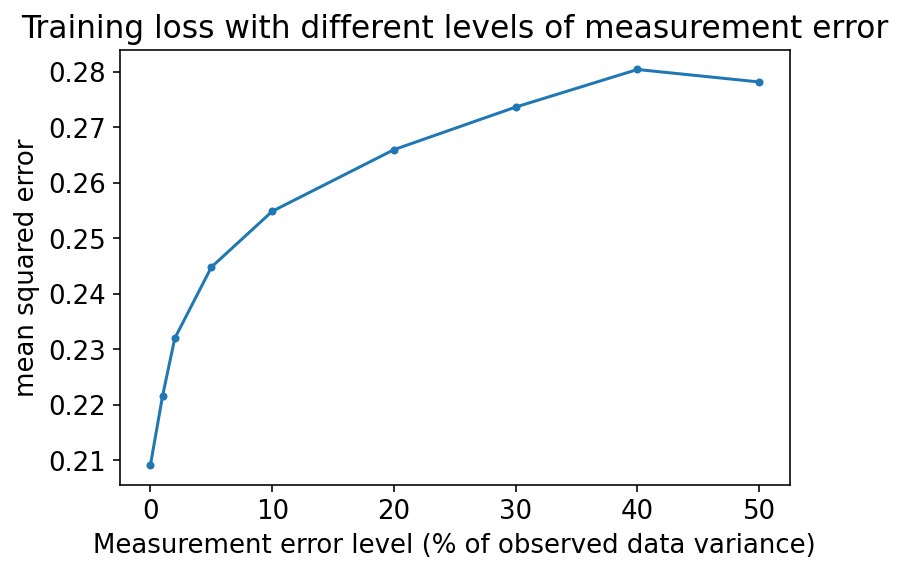

In [42]:
plt.plot(((error_var_scale)*100),train_loss,'.-')
plt.title('Training loss with different levels of measurement error')
plt.xlabel('Measurement error level (% of observed data variance)')
plt.ylabel('mean squared error')

Text(0.5, 0, 'Measurement error level (% of observed data variance)')

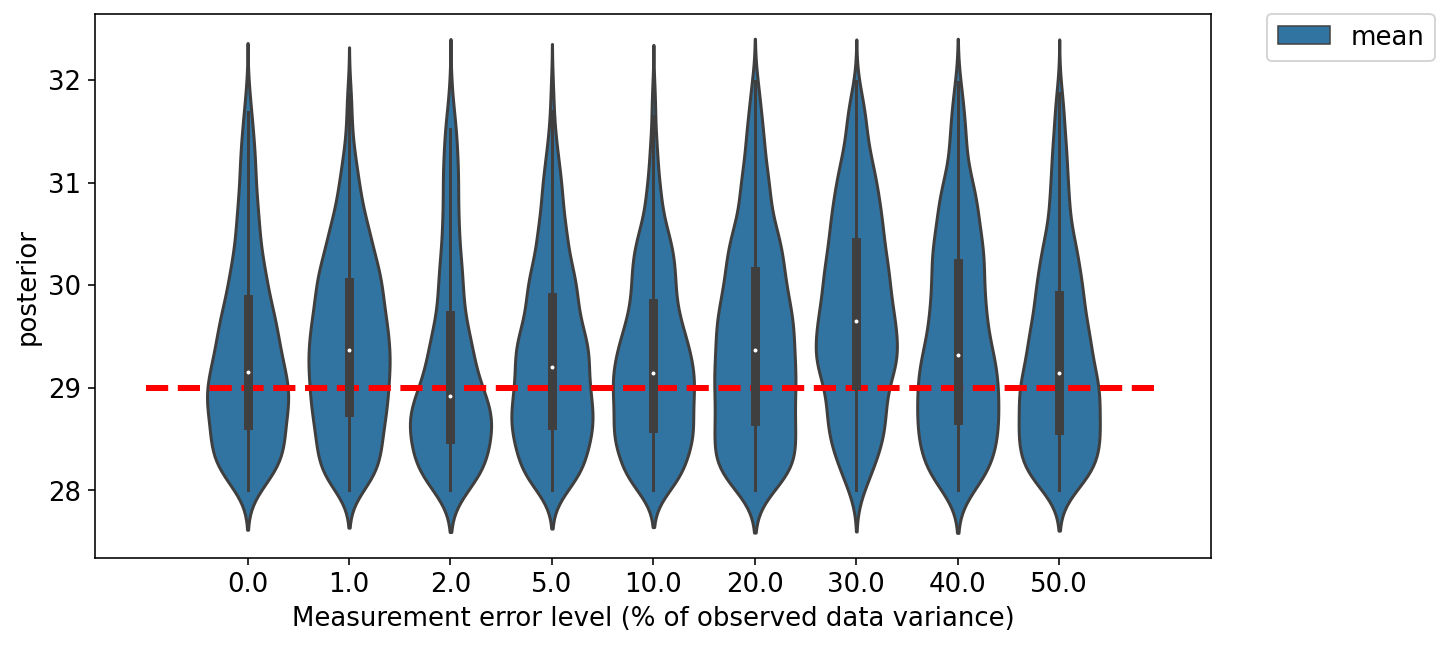

In [43]:
plt.figure(figsize=[10,5])
sns.violinplot(x="error_level", y="posterior", hue="theta",data=theta_error_DF[theta_error_DF["theta"] =='mean'], palette="tab10")
plt.hlines(y = theta_true[0],xmin = -1,xmax =9,linestyle = '--',linewidth = 3, color = 'red')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Measurement error level (% of observed data variance)')

Text(0.5, 0, 'Measurement error level (% of observed data variance)')

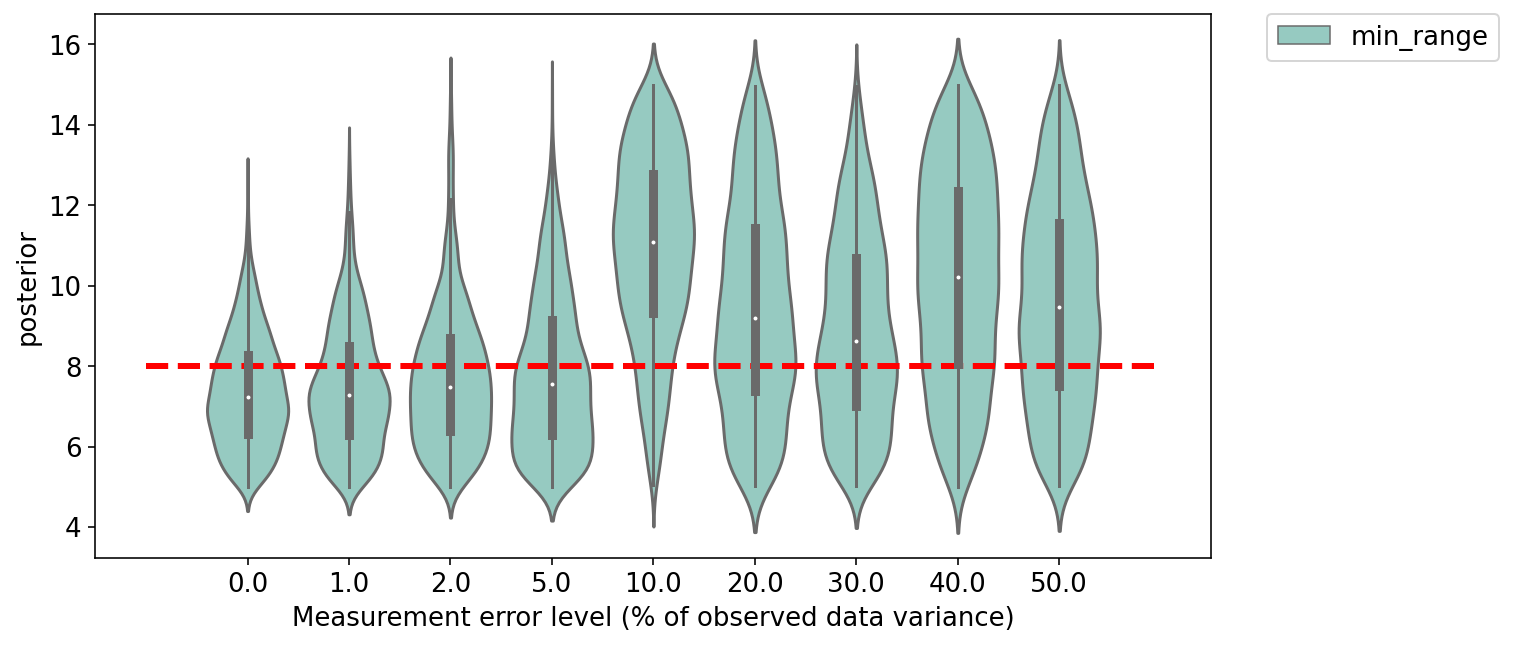

In [44]:
plt.figure(figsize=[10,5])
sns.violinplot(x="error_level", y="posterior", hue="theta",data=theta_error_DF[theta_error_DF["theta"] =='min_range'], palette="Set3")
plt.hlines(y = theta_true[3],xmin = -1,xmax =9,linestyle = '--',linewidth = 3, color = 'red')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Measurement error level (% of observed data variance)')

## Markov chain Monte Carlo, posterior $\theta$

In [ ]:
# You can run this McMC code by yourself, that will take ~20mins
trace = McMC(G, d_obs)

In [ ]:
theta_pos_McMC = np.vstack([trace['mean'],trace['variance'],trace['max_range'],trace['min_range'],trace['anisotropy']])

In [ ]:
prior_pos_theta(theta, theta_pos_McMC, theta_true, theta_name)

In [48]:
#np.save(path+'saved_inverse_results/posterior_McMC.npy',theta_pos_McMC)
theta_pos_McMC = np.load(path+'/saved_inverse_results/posterior_McMC.npy')

### Likelihood under the linear gaussian assumption for McMC method

In [34]:
from scipy.stats import multivariate_normal

def rotation_matrix_(anisotropy):
    angle = anisotropy*(np.pi/180)
    r_matrix = np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])
    return r_matrix

def likelihood(theta):
    # domain size
    num_x = 70
    num_y = 30

    # x,y range, for covariance matrix calculation
    x = np.arange(-num_x,num_x)
    y = np.arange(-num_y,num_y)
    xx,yy = np.meshgrid(x,y)
    xx = xx.T
    yy = yy.T
    
    # linear forward modeling, smooth filter
    ## linear forward modeling: G
    idx_m_list = np.where(np.sum(G,axis = 0)>0)[0] # idx of m impacts d
    
    mean, variance, max_range, min_range, anisotropy = theta
    mu_test = np.dot(G,np.zeros(G.shape[1])+mean)

    h = np.dot(rotation_matrix_(anisotropy),
               np.vstack([xx.reshape(-1),yy.reshape(-1)]))/np.array([max_range,min_range]).reshape(-1,1)

    cov_entire = variance*np.exp(-(np.pi/4)*(np.sqrt(h[0,:]**2+h[1,:]**2)*np.sqrt(3))**2)
    cov_entire = cov_entire.reshape(num_x*2,num_y*2)
    C_m = np.zeros((num_x*num_y,num_x*num_y))
    for i in range(num_x):
        for j in range(num_y):
            idx = i*num_y+j
            if idx in idx_m_list:
                C_m[i*num_y+j,:] = cov_entire[(num_x-i):(num_x*2-i),(num_y-j):(num_y*2-j)].reshape(-1)

    cov_test = np.dot(np.dot(G,C_m),G.T)
    p = multivariate_normal.pdf(d_obs.reshape(-1), mean=mu_test, cov=cov_test)
    return p

In [50]:
McMC_pos_likelihood = [likelihood(theta_pos_McMC[:,i]) for i in tqdm(range(theta_pos_McMC.shape[1]))]

100%|██████████| 2000/2000 [01:09<00:00, 28.93it/s]


In [51]:
ML_based_pos_likelihood = [likelihood(theta_pos_MC[:,i]) for i in tqdm(range(theta_pos_MC.shape[1]))]

100%|██████████| 2000/2000 [01:09<00:00, 28.78it/s]


Text(0.5, 0, 'anisotropy')

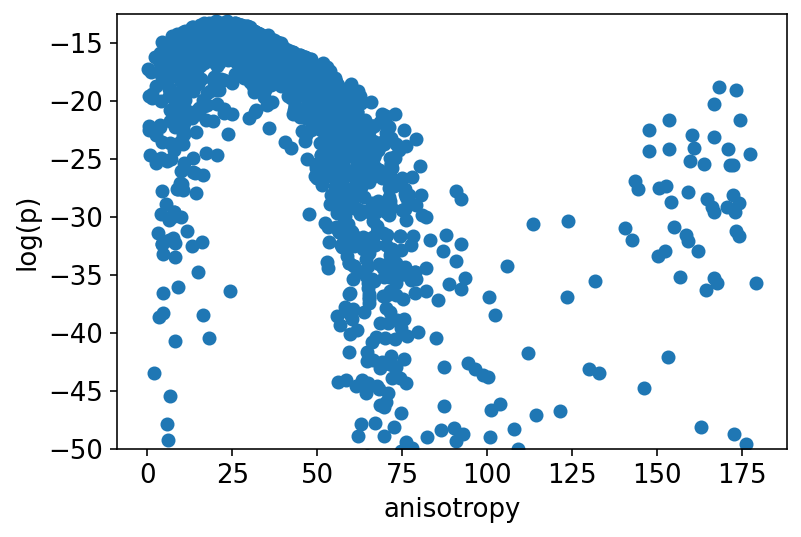

In [52]:
# ML-based method, likelihood -> likelihood is defined given linear Gaussian assumptions
# We don't assume linear Gaussian assumptions in the ML-based method
plt.scatter(theta_pos_MC[4,:],np.log10(np.array(ML_based_pos_likelihood)+1e-300))

plt.ylim(-50,-12.5)
plt.ylabel('log(p)')
plt.xlabel('anisotropy')

(-17.0, -12.5)

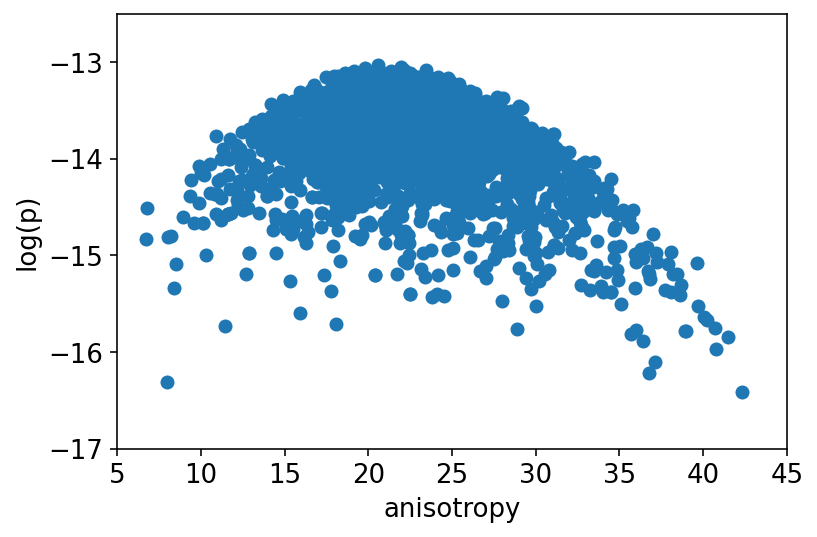

In [53]:
plt.scatter(theta_pos_McMC[4,:],np.log10(np.array(McMC_pos_likelihood)+1e-300))
plt.ylabel('log(p)')
plt.xlabel('anisotropy')
plt.xlim(5,45)
plt.ylim(-17,-12.5)

## Posterior $m$

### Using global posterior from MCMC

In [54]:
pos_theta = np.load(path+'/saved_inverse_results/posterior_theta_McMC_case1.npy').T

In [55]:
# update spatial variable only given different uncertain global variable
num_scenario_C = 100
mu_pos_en = np.zeros(num_x*num_y)
cov_m_pos_en = np.zeros((num_x*num_y,num_x*num_y))
m_pos_scenario_C = np.zeros((num_scenario_C,num_m))
for iter_num in tqdm(range(num_scenario_C)):
    theta_current = pos_theta[iter_num,:]
    mu_pos, cov_m_pos = bayes_linear_gauss_closed_form(theta_current,G,d_obs)
    mu_pos_en = mu_pos_en+mu_pos
    cov_m_pos_en = cov_m_pos_en+cov_m_pos
    m_pos_sampled = sample_mvn(mu_pos, cov_m_pos,num_sample=1)
    m_pos_scenario_C[iter_num,:] = m_pos_sampled.reshape(-1)

100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


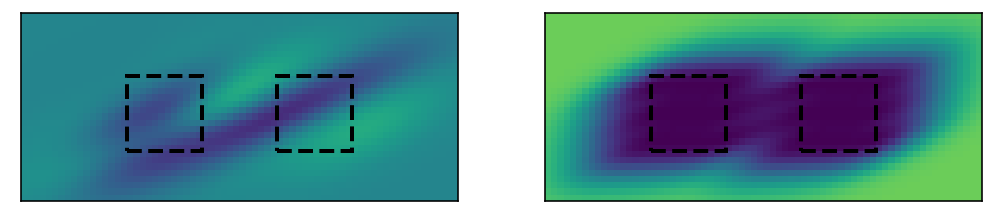

In [56]:
# mean and variance
mu_pos_en = mu_pos_en/num_scenario_C
cov_m_pos_en = cov_m_pos_en/num_scenario_C
visualize_mean_var(mu_pos_en, cov_m_pos_en)

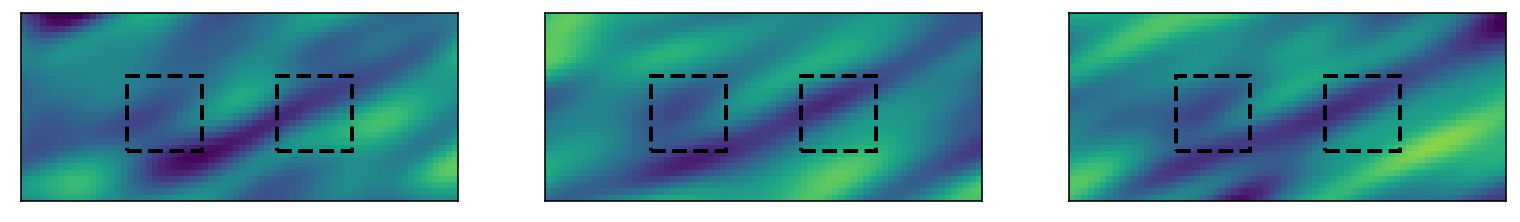

In [57]:
# Posterior realizations
visualize_multiple_m(m_pos_scenario_C[[0,1,8],:],head = 3)

### Using global posterior from ML-based model

In [58]:
pos_theta = np.load(path+'/saved_inverse_results/posterior_ML_MC.npy').T

In [59]:
# update spatial variable only given different uncertain global variable
num_scenario_C = 100
mu_pos_en = np.zeros(num_x*num_y)
cov_m_pos_en = np.zeros((num_x*num_y,num_x*num_y))
m_pos_scenario_C = np.zeros((num_scenario_C,num_m))
for iter_num in tqdm(range(num_scenario_C)):
    theta_current = pos_theta[iter_num,:]
    mu_pos, cov_m_pos = bayes_linear_gauss_closed_form(theta_current,G,d_obs)
    mu_pos_en = mu_pos_en+mu_pos
    cov_m_pos_en = cov_m_pos_en+cov_m_pos
    m_pos_sampled = sample_mvn(mu_pos, cov_m_pos,num_sample=1)
    m_pos_scenario_C[iter_num,:] = m_pos_sampled.reshape(-1)

100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


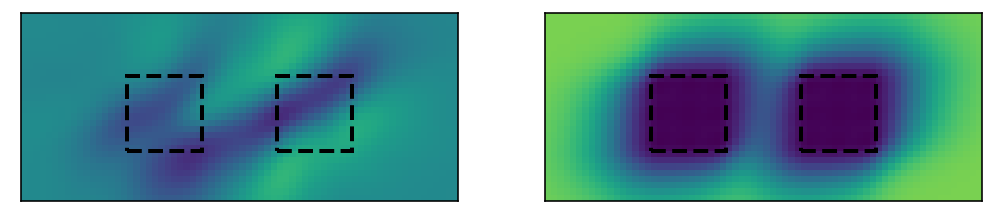

In [60]:
# mean and variance
mu_pos_en = mu_pos_en/num_scenario_C
cov_m_pos_en = cov_m_pos_en/num_scenario_C
visualize_mean_var(mu_pos_en, cov_m_pos_en)

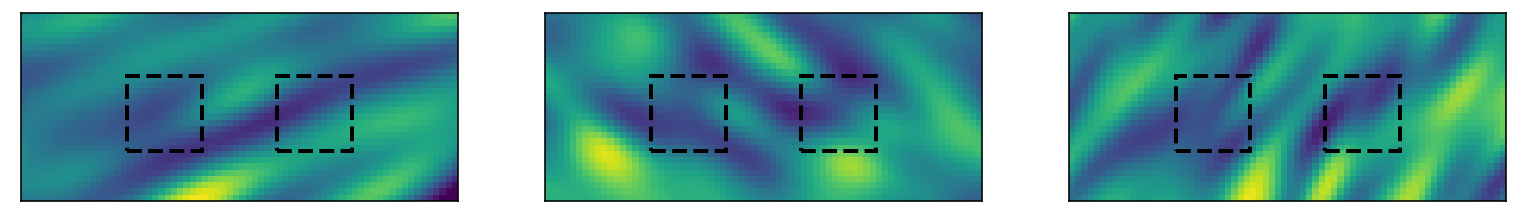

In [61]:
# Posterior realizations
visualize_multiple_m(m_pos_scenario_C[[2,23,29],:],head = 3)